<a href="https://colab.research.google.com/github/vaibhav0012/Image-Caption-Generator/blob/main/Caption_Generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets list

ref                                                       title                                           size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------  ---------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
haseebindata/student-performance-predictions              Student Performance Predictions                  9KB  2024-08-17 06:57:57           9914        216  0.9411765        
lainguyn123/student-performance-factors                   Student Performance Factors                     94KB  2024-09-02 10:53:57           3142         76  1.0              
hanaksoy/customer-purchasing-behaviors                    Customer Purchasing Behaviors                    1KB  2024-09-01 22:18:07           2058         29  1.0              
abdullah0a/human-age-prediction-synthetic-dataset         Human Age Prediction Synthetic Dataset         739KB  202

In [ ]:
! kaggle datasets download -d bsnllover/flikr-8k-dataset

Dataset URL: https://www.kaggle.com/datasets/bsnllover/flikr-8k-dataset
License(s): unknown
 99% 1.03G/1.04G [00:13<00:00, 70.9MB/s]
100% 1.04G/1.04G [00:13<00:00, 83.9MB/s]


In [ ]:
! unzip flikr-8k-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Images/2844747252_64567cf14a.jpg  
  inflating: Images/2844846111_8c1cbfc75d.jpg  
  inflating: Images/2844963839_ff09cdb81f.jpg  
  inflating: Images/2845246160_d0d1bbd6f0.jpg  
  inflating: Images/2845691057_d4ab89d889.jpg  
  inflating: Images/2845845721_d0bc113ff7.jpg  
  inflating: Images/2846037553_1a1de50709.jpg  
  inflating: Images/2846785268_904c5fcf9f.jpg  
  inflating: Images/2846843520_b0e6211478.jpg  
  inflating: Images/2847514745_9a35493023.jpg  
  inflating: Images/2847615962_c330bded6e.jpg  
  inflating: Images/2847859796_4d9cb0d31f.jpg  
  inflating: Images/2848266893_9693c66275.jpg  
  inflating: Images/2848571082_26454cb981.jpg  
  inflating: Images/2848895544_6d06210e9d.jpg  
  inflating: Images/2848977044_446a31d86e.jpg  
  inflating: Images/2849194983_2968c72832.jpg  
  inflating: Images/2850719435_221f15e951.jpg  
  inflating: Images/2851198725_37b6027625.jpg  
  inflating: Images/2851304910_b57211

In [5]:
!unzip captions.txt.zip

Archive:  captions.txt.zip
  inflating: captions.txt            


In [6]:
import os
cwd = os.getcwd()
print(cwd)
! ls

/content
captions.txt  captions.txt.zip	image_features.pkl  sample_data


In [7]:
import os
cwd = os.getcwd()
base_path = ''
image_dir = os.path.join(base_path, 'data')
captions = os.path.join(base_path, 'captions.txt')
Images = os.path.join(base_path, 'Images')

In [8]:
import pandas as pd
data = pd.read_csv(captions)
data.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [9]:
! pip install --upgrade pip
! pip install torch torchvision torchsummary gca pandas numpy matplotlib seaborn scikit-learn tqdm umap-learn kneed


  Using cached pip-24.2-py3-none-any.whl.metadata (3.6 kB)
Using cached pip-24.2-py3-none-any.whl (1.8 MB)
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
  Preparing metadata (setup.py) ... done
  Created wheel for gca: filename=gca-0.1-py3-none-any.whl size=12273 sha256=620388e076004ea15637beaba9650cc2f5a091c256b688e5eaaae7a088c2f109
  Stored in directory: /root/.cache/pip/wheels/41/29/fb/680ba51f8d9f3e1b62c9f1db41153ec9121b9a4e76fdd788d9
Successfully built gca


In [ ]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print(torch.cuda.current_device())
    print(torch.cuda.device_count())
    print(torch.cuda.get_device_name(0))

device

0
1
Tesla T4


device(type='cuda', index=0)

In [ ]:
model = torch.hub.load('facebookresearch/WSL-Images', 'resnext101_32x8d_wsl')

Downloading: "https://github.com/facebookresearch/WSL-Images/zipball/main" to /root/.cache/torch/hub/main.zip
Downloading: "https://download.pytorch.org/models/ig_resnext101_32x8-c38310e5.pth" to /root/.cache/torch/hub/checkpoints/ig_resnext101_32x8-c38310e5.pth
100%|██████████| 340M/340M [00:01<00:00, 274MB/s]


In [ ]:
from torch import nn
from torchsummary import summary

# Dropping output layer (the ImageNet classifier)

def slice_model(original_model, from_layer=None, to_layer=None):
    return nn.Sequential(*list(original_model.children())[from_layer:to_layer])
model_conv_features = slice_model(model, to_layer=-1).to(device)
summary(model_conv_features, input_size=(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5          [-1, 256, 56, 56]          16,384
       BatchNorm2d-6          [-1, 256, 56, 56]             512
              ReLU-7          [-1, 256, 56, 56]               0
            Conv2d-8          [-1, 256, 56, 56]          18,432
       BatchNorm2d-9          [-1, 256, 56, 56]             512
             ReLU-10          [-1, 256, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          65,536
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from textwrap import wrap
import torch
import numpy as np

def readImage(path, img_size=224):
    # Open an image file
    img = Image.open(path).convert('RGB')

    # Define transformations
    transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Standard ImageNet means
                             std=[0.229, 0.224, 0.225])  # Standard ImageNet std deviation
    ])

    # Apply transformations
    img = transform(img)

    return img

def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize=(20, 20))

    for i in range(15):
        plt.subplot(5, 5, i + 1)
        plt.subplots_adjust(hspace=0.7, wspace=0.3)

        # Read and prepare the image
        image = readImage(f"Images/{temp_df.image[i]}")

        # Convert the PyTorch tensor to a numpy array
        # and reverse the order of axes from (C, H, W) to (H, W, C)
        image = image.numpy().transpose(1, 2, 0)

        # Normalize the pixel values to [0, 1]
        image = image * torch.tensor([0.229, 0.224, 0.225]).numpy() + torch.tensor([0.485, 0.456, 0.406]).numpy()
        image = np.clip(image, 0, 1)  # Ensure the pixel values are clipped to [0, 1] range

        # Display the image
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.caption[i], 20)))
        plt.axis("off")

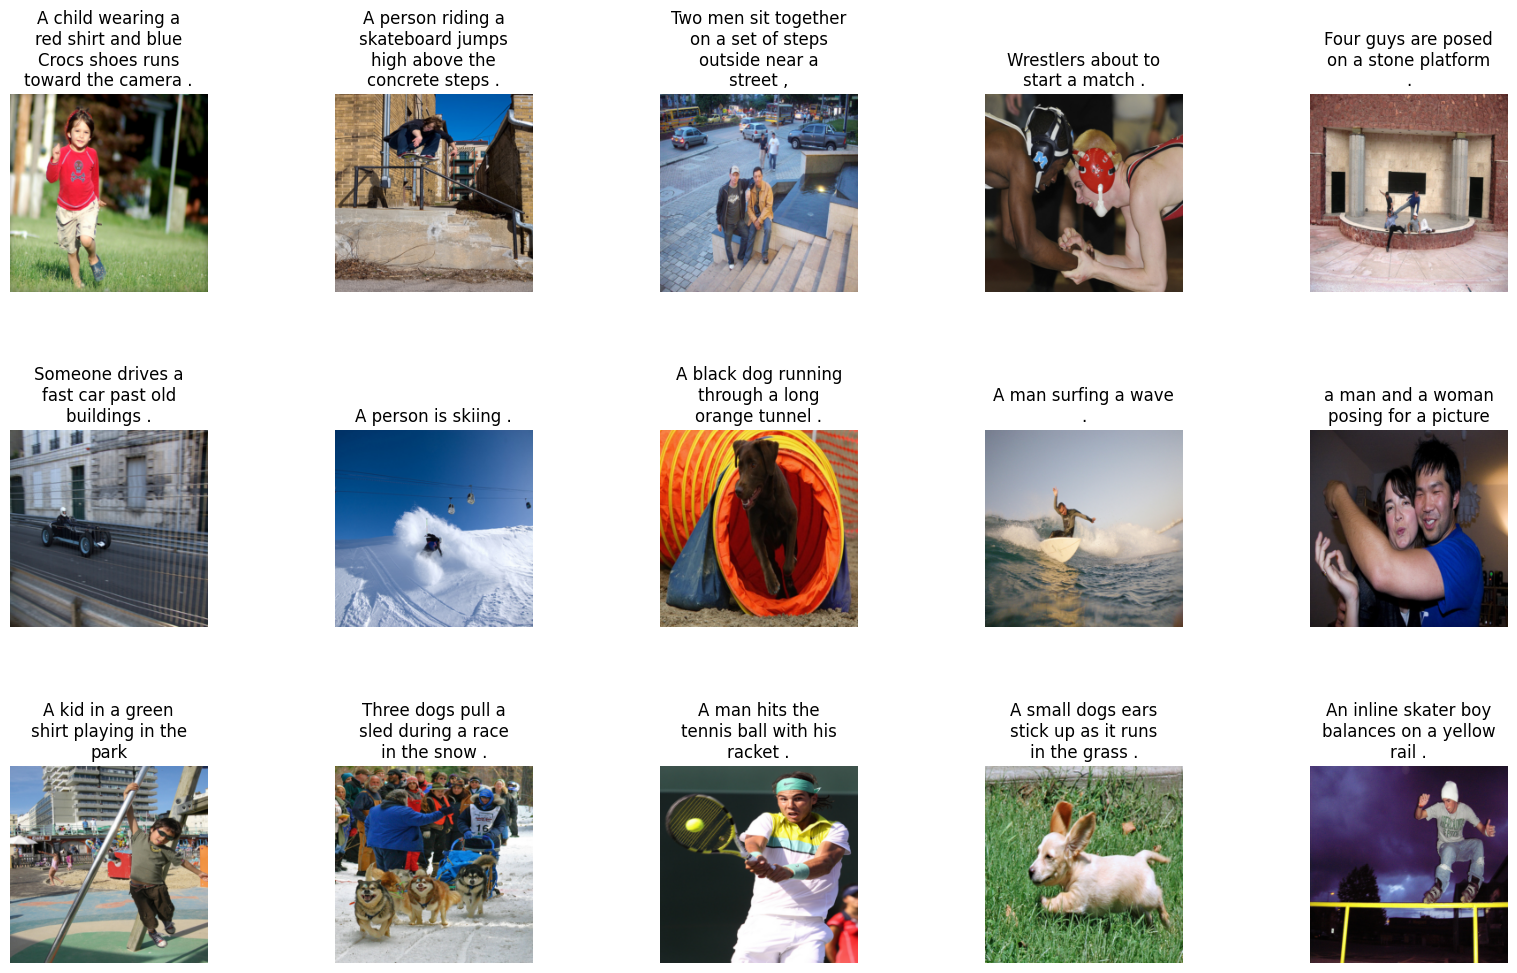

In [ ]:
display_images(data.sample(15))

In [ ]:
from tqdm import tqdm
features ={}
for image in tqdm(data['image'].unique().tolist()):
    img_path = os.path.join(Images, image)
    img = readImage(img_path)
    img_tensor = img.unsqueeze(0).to(device)

    with torch.no_grad():
        feature = model_conv_features(img_tensor)

    features[image] = feature.cpu().numpy()

In [ ]:
import pickle
features_file_path = 'image_features.pkl'

In [ ]:
with open(features_file_path, 'wb') as f:
    pickle.dump(features, f)

NameError: name 'features_file_path' is not defined

In [ ]:
# To load the features dictionary later
with open(features_file_path, 'rb') as f:
    loaded_features = pickle.load(f)
loaded_features

{'1000268201_693b08cb0e.jpg': array([[[[0.18317588]],
 
         [[0.44425306]],
 
         [[0.3388399 ]],
 
         ...,
 
         [[0.3494142 ]],
 
         [[0.36456135]],
 
         [[0.4110801 ]]]], dtype=float32),
 '1001773457_577c3a7d70.jpg': array([[[[0.25912791]],
 
         [[0.37593254]],
 
         [[0.31931722]],
 
         ...,
 
         [[0.28987852]],
 
         [[0.31553558]],
 
         [[0.39983532]]]], dtype=float32),
 '1002674143_1b742ab4b8.jpg': array([[[[0.2694787 ]],
 
         [[0.5679821 ]],
 
         [[0.35347188]],
 
         ...,
 
         [[0.40792304]],
 
         [[0.33736354]],
 
         [[0.60733414]]]], dtype=float32),
 '1003163366_44323f5815.jpg': array([[[[0.27147776]],
 
         [[0.5356138 ]],
 
         [[0.44929212]],
 
         ...,
 
         [[0.39075813]],
 
         [[0.43987948]],
 
         [[0.32564613]]]], dtype=float32),
 '1007129816_e794419615.jpg': array([[[[0.24287306]],
 
         [[0.6071331 ]],
 
         [[0.47661328]],


In [ ]:
data.head(20)

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...
5,1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting
6,1001773457_577c3a7d70.jpg,A black dog and a tri-colored dog playing with...
7,1001773457_577c3a7d70.jpg,A black dog and a white dog with brown spots a...
8,1001773457_577c3a7d70.jpg,Two dogs of different breeds looking at each o...
9,1001773457_577c3a7d70.jpg,Two dogs on pavement moving toward each other .


In [10]:
import string
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import pandas as pd

# Ensure nltk resources are available
import nltk
nltk.download('punkt')
nltk.download('stopwords')

def preprocess_captions(df: pd.DataFrame) -> pd.DataFrame:
    # Define a single function to handle all string preprocessing
    def clean_caption(caption):
        # Lowercase the caption
        caption = caption.lower()
        # Remove punctuation
        caption = caption.translate(str.maketrans('', '', string.punctuation))
        # Remove non-letter characters and extra spaces
        caption = re.sub(r'[^a-z\s]', '', caption)
        caption = re.sub(r'\s+', ' ', caption).strip()
        # Add start and end tokens
        return '<start> ' + caption + ' <end>'

    # Apply the cleaning function to each caption
    df['caption'] = df['caption'].apply(lambda x: clean_caption(x))

    # Tokenization and optional stop words removal
    stop_words = set(stopwords.words('english'))
    df['caption_tokens'] = df['caption'].apply(lambda x: [word for word in word_tokenize(x) if word not in stop_words])

    return df

# Example usage
preprocessed_df = preprocess_captions(data)
preprocessed_df.head()


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,image,caption,caption_tokens
0,1000268201_693b08cb0e.jpg,<start> a child in a pink dress is climbing up...,"[<, start, >, child, pink, dress, climbing, se..."
1,1000268201_693b08cb0e.jpg,<start> a girl going into a wooden building <end>,"[<, start, >, girl, going, wooden, building, <..."
2,1000268201_693b08cb0e.jpg,<start> a little girl climbing into a wooden p...,"[<, start, >, little, girl, climbing, wooden, ..."
3,1000268201_693b08cb0e.jpg,<start> a little girl climbing the stairs to h...,"[<, start, >, little, girl, climbing, stairs, ..."
4,1000268201_693b08cb0e.jpg,<start> a little girl in a pink dress going in...,"[<, start, >, little, girl, pink, dress, going..."


In [13]:
preprocessed_df.to_csv('preprocessed_df.csv')

In [14]:
len(preprocessed_df)

40455